# The Battle of Neighborhoods (Week 2)

## Applied Data Science Capstone - Capstone Project 
CK, July 2019

## Table of contents<a name="TOC"></a>
* [Background](#background)  
  * [Objective](#objective)  
  * [Audience](#audience)  
* [Libraries](#lib)
* [Data](#data)  
  * [Data Scrapping and Cleaning](#scrap)
* [Methodology](#methodology)
* [Exploratory Data Analysis](#exp)
* [Clustering](#clust)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

# Background <a name="background"></a>

With most of us are becoming increasingly health conscious, popularity of fitness centres is proliferating. Growing indorsements from celebrities and athletes for different fitness franchises are adding awareness to the fitness industry. The Australian fitness industry is now worth around **$2.4 billion**, according to IbisWorld research company.

## Objective <a name="objective"></a> 
Main objective is to determine the **10** best possible postcodes/boroughs in **Central & Inner Metropolitan Sydney, Australia** to setup a fitness centre. The postcode range is 2000 - 2050. The centre will be welcoming all ages and fitness enthusiastic from all socio-economic backgrounds. However, according to the Australian Bureau of Statistics in 2016(Census), 18-34-year-olds are Australia’s top fitness demographic. Therefore, in this project focus will be age group 20-39 whose weekly income between AUD 1000 - 1999. Another variable will be count of fitness centres already in each postcode.

## Audience <a name="audience"></a>
Target audience of this project will be business entrepreneurs and fitness franchisees looking at expanding.  

[TOP](#TOC)

# Libraries <a name="lib"></a>
Import following required libraries:

In [2]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import re # importing re for regular expressions 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import IPython

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


[TOP](#TOC)

# Data <a name="data"></a>

Following data will be used to achieve the project objective:  

1. Fitness centres in postcodes 2000 to 2050, 500m radius from postcode centre (longitude/latitude). Foursquare location data will be used to obtain this data  
    
2. Postcodes that fall within Central and Inner Metropolitan Sydney. Following weblink contains the required data, 
   relevant data is extracted and saved as a CSV file for use: https://www.prospectshop.com.au/Files/SydneyMetro_Postcodes.xls : *SydneyMetro_Postcodes.csv* 
    
3. Suburb (Neighbourhood) names associated with each postcode were extracted from:  
   https://www.costlessquotes.com.au/postcode_tool/postcode_list_NSW.php and save as a CSV file for use: *SuburbNames.csv*  
   
4. Geo data, longitude and latitude for each postcode were downloaded as a CSV file for use: https://www.matthewproctor.com/australian_postcodes: *australian_postcodes.csv*
    
5. Demographic data, population age between 20-39 with weekly income between AUD 1000 - 1999 is extracted and saved as a CSV file from Australian   Bureau of Statistics: 
https://www.abs.gov.au/websitedbs/D3310114.nsf/Home/2016%20TableBuilder . Free account was setup to use *TableBuilder* to   
   extract data from latest Census held in 2016 : *DemographicPopulation.csv* 
    
With these data, density of target population and fitness centres can be determined.

## Data Scrapping and Cleaning<a name="scrap"></a>

### Postcode data

In [3]:
## Postcodes within Central and Inner Metropolitan Sydney  
postCodedf = pd.read_csv("SydneyMetro_Postcodes.csv")
print("Postcodes: {}".format(postCodedf.shape[0]))
postCodedf.head()

Postcodes: 42


,Postcode,Suburb
0,2000,Sydney City
1,2007,Ultimo
2,2008,Chippendale
3,2009,Pyrmont
4,2010,Surry Hills


In [4]:
## All suburb names for each postcode 
subnamedf = pd.read_csv("SuburbNames.csv")
print("Suburb rows: {}".format(subnamedf.shape[0]))
subnamedf.head()

Suburb rows: 47


,Postcode,District,Suburbs
0,2000,Sydney,"Dawes Point, Haymarket, Millers Point, Sydney,..."
1,2001,Sydney,Sydney
2,2002,Sydney,World Square
3,2004,Sydney,Eastern Suburbs
4,2006,Sydney,University Of Sydney


In [5]:
# Merge two dataframes
dfpostcodes = pd.merge(postCodedf, subnamedf, on='Postcode')

# Drop "Suburb" and "District" columns
dfpostcodes.drop(["Suburb","District"], axis=1, inplace=True)

print("Cleaned postcode df: {}".format(dfpostcodes.shape[0]))
dfpostcodes.head()

Cleaned postcode df: 42


,Postcode,Suburbs
0,2000,"Dawes Point, Haymarket, Millers Point, Sydney,..."
1,2007,Ultimo
2,2008,"Chippendale, Darlington"
3,2009,Pyrmont
4,2010,"Surry Hills, Darlinghurst"


In [6]:
## Merge Geo data
geodf = pd.read_csv("australian_postcodes.csv")

geodf.rename(columns={'postcode':'Postcode'}, inplace=True)

# Drop "locality","State","id","dc","type","status" columns
geodf.drop(["locality","State","id","dc","type","status"], axis=1, inplace=True)

# Drop Nan rows
geodf.dropna(inplace=True)

# Drop duplicate rows
geodf.drop_duplicates(inplace=True)

dfpostcodegeo = pd.merge(dfpostcodes, geodf, on='Postcode')

print("Postcodes with geo data: {}".format(dfpostcodegeo.shape[0]))
dfpostcodegeo.head()



Postcodes with geo data: 42


,Postcode,Suburbs,long,lat
0,2000,"Dawes Point, Haymarket, Millers Point, Sydney,...",151.256649,-33.859953
1,2007,Ultimo,151.196650,-33.883189
2,2008,"Chippendale, Darlington",151.193858,-33.891146
3,2009,Pyrmont,151.193055,-33.871222
4,2010,"Surry Hills, Darlinghurst",151.212262,-33.884119


In [7]:
## Now population data
popdf = pd.read_csv("DemographicPopulation.csv")
print("Population: {}".format(popdf.shape[0]))
popdf.head()

Population: 42


,Postcode,Population
0,2000,5477
1,2007,1542
2,2008,2727
3,2009,2913
4,2010,6774


In [8]:
# Postcode and population dataframes
dfpostcodePop = pd.merge(dfpostcodegeo, popdf, on='Postcode')

print("Cleaned postcode df: {}".format(dfpostcodePop.shape[0]))
dfpostcodePop.head()

Cleaned postcode df: 42


,Postcode,Suburbs,long,lat,Population
0,2000,"Dawes Point, Haymarket, Millers Point, Sydney,...",151.256649,-33.859953,5477
1,2007,Ultimo,151.196650,-33.883189,1542
2,2008,"Chippendale, Darlington",151.193858,-33.891146,2727
3,2009,Pyrmont,151.193055,-33.871222,2913
4,2010,"Surry Hills, Darlinghurst",151.212262,-33.884119,6774


### Fitness Centre data

In [9]:
# Using FourSquare, get all gyms within 500m radius for the postcodes
# User credential used are hidden in this report

In [10]:
# @hidden_cell
CLIENT_ID = 'IRCDYMHPDJIZP01QT3AHJXRZPQQ3BRAE5C4SC10KRIPM2TB1' # Foursquare ID
CLIENT_SECRET = 'Q3E42YGQW5YRCIWDZQRCAN13DAJJJM34S04CM2TPKZ10SXDU' # Foursquare Secret

In [11]:
VERSION = '20190801' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# From the Foursquare website, https://developer.foursquare.com/docs/resources/categories
# Category for Gym / Fitness Center is 4bf58dd8d48988d175941735
VenueCat = '4bf58dd8d48988d175941735'

In [12]:
def getNearbyFitness(postcodes, latitudes, longitudes):
    
    fitness_list=[]
    for pc, lat, lng in zip(postcodes, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&categoryId={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            VenueCat, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        fitness_list.append([(
            pc, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['location']['distance']) for v in results])
        
    nearby_venues = pd.DataFrame([item for fit_list in fitness_list for item in fit_list])
    nearby_venues.columns = ['Postcode', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'VenueLatitude', 
                  'VenueLongitude', 
                  'Category',
                  'Distance']
    
    return(nearby_venues)

For each postcode get fitness centres using the above function

In [13]:

fitcentres = getNearbyFitness(postcodes=dfpostcodePop['Postcode'],
                                   latitudes=dfpostcodePop['lat'],
                                   longitudes=dfpostcodePop['long']
                                  )

In [14]:
print(fitcentres.shape)
fitcentres.head()

(138, 8)


,Postcode,Latitude,Longitude,Venue,VenueLatitude,VenueLongitude,Category,Distance
0,2007,-33.883189,151.19665,Broadway Gym,-33.884354,151.196410,Gym / Fitness Center,131
1,2007,-33.883189,151.19665,Victoria Park Swimming Pool,-33.885721,151.194119,Pool,366
2,2007,-33.883189,151.19665,Anytime Fitness,-33.884094,151.192730,Gym,376
3,2007,-33.883189,151.19665,Fernwood,-33.883430,151.194895,Gym / Fitness Center,164
4,2007,-33.883189,151.19665,Members Health Gym,-33.883620,151.198080,Gym,140


From the excerpt of the foursquare dataframe above, it is clear we need to clean the data and remove records where *Venue Category* is not Gym / Fitness Center  

In [15]:
# Make the search for venue cateogry case insensitive
fitlist = ['gym / fitness center','gym', 'fitness center','fitness centre']
onlyfitcentres = fitcentres[fitcentres['Category'].str.lower().isin(fitlist)]

print(onlyfitcentres.shape)
onlyfitcentres.head()

(93, 8)


,Postcode,Latitude,Longitude,Venue,VenueLatitude,VenueLongitude,Category,Distance
0,2007,-33.883189,151.19665,Broadway Gym,-33.884354,151.196410,Gym / Fitness Center,131
2,2007,-33.883189,151.19665,Anytime Fitness,-33.884094,151.192730,Gym,376
3,2007,-33.883189,151.19665,Fernwood,-33.883430,151.194895,Gym / Fitness Center,164
4,2007,-33.883189,151.19665,Members Health Gym,-33.883620,151.198080,Gym,140
5,2007,-33.883189,151.19665,iTrain Fitness Boutique Gym,-33.883527,151.195805,Gym,86


Group number of fitness centres by postcode and merge with population dataframe, for postcodes with no fitness centres display zero (0)

In [16]:
grpfit = onlyfitcentres.groupby('Postcode').count()[['Venue']].reset_index(level=0)

# Merge dataframes
dfpopfit = pd.merge(dfpostcodePop, grpfit, on='Postcode', how ='left')
dfpopfit.fillna(0, inplace=True)

# Create a column with fitness centres to population ratio
dfpopfit['fitPopulRatio']=dfpopfit.Venue/dfpopfit.Population

dfpopfit.head()

,Postcode,Suburbs,long,lat,Population,Venue,fitPopulRatio
0,2000,"Dawes Point, Haymarket, Millers Point, Sydney,...",151.256649,-33.859953,5477,0.0,0.000000
1,2007,Ultimo,151.196650,-33.883189,1542,8.0,0.005188
2,2008,"Chippendale, Darlington",151.193858,-33.891146,2727,0.0,0.000000
3,2009,Pyrmont,151.193055,-33.871222,2913,3.0,0.001030
4,2010,"Surry Hills, Darlinghurst",151.212262,-33.884119,6774,7.0,0.001033


[TOP](#TOC)

# Methodology<a name="methodology"></a>

The objective is to find postcodes with low density fitness centres in inner Sydney.

Now that data wrangling phase is completed. Will be moving to Analysis

Exploratory analysis will be looking at the fitness centre ratio to the target demographic, highlighting the postcodes with zero(0) ratio in a map of Sydney. Also, sorting the records by the ratio and population gives a better understanding of postcodes that are better candidates for a fitness centre.

Finally, **k-mean clustering** will be used to identify the clusters of postcodes with different densities. To start this, best value for **k** is determined by calculating the distance to the centriod and using the *Elbow Method*. This analysis will provide a narrowed list of postcodes as a starting point for *street level* research for best locations within selected postcodes.

## Exploratory Data Analysis<a name="exp"></a>

Let's order the postcodes by ratio of fitness centres to population and total popluation to determine less denser postcodes.

In [17]:
dfpopfit.sort_values(['fitPopulRatio', 'Population'], axis=0, ascending=[True,False]).head(10)

,Postcode,Suburbs,long,lat,Population,Venue,fitPopulRatio
0,2000,"Dawes Point, Haymarket, Millers Point, Sydney,...",151.256649,-33.859953,5477,0.0,0.000000
11,2020,Mascot,151.176775,-33.936179,3503,0.0,0.000000
2,2008,"Chippendale, Darlington",151.193858,-33.891146,2727,0.0,0.000000
10,2019,"Banksmeadow, Botany",151.207285,-33.946923,1782,0.0,0.000000
38,2047,Drummoyne,151.165735,-33.853924,1776,0.0,0.000000
39,2048,Stanmore,151.165640,-33.894180,1755,0.0,0.000000
35,2044,"St Peters, Sydenham, Tempe",151.170740,-33.920698,1644,0.0,0.000000
15,2024,"Bronte, Waverley",151.259392,-33.904414,1537,0.0,0.000000
20,2029,Rose Bay,151.266989,-33.875709,1361,0.0,0.000000
25,2034,"Coogee, South Coogee",151.252171,-33.929096,3980,1.0,0.000251


There are few postcodes with no fitness centres, now is a good time to visualise these in a map.

## Map of Sydney
Let's visualise the postcode locations selected around Sydney, highlighting in red postcodes with **NO** fitness centres.  
To Generate the map, the geographical coordinates of Sydney are obtained using geocoder. In order to define an instance of the geocoder, a user_agent is defined <em>syd_explorer</em>.

In [18]:
address = 'Sydney, NSW'

geolocator = Nominatim(user_agent="syd_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sydney are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sydney are -33.8548157, 151.2164539.


In [19]:
# Create map of Sydney using latitude and longitude values
map_sydney = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to the map
for lat, lng, pc, subs, ratio in zip(dfpopfit['lat'], dfpopfit['long'], dfpopfit['Postcode'], dfpopfit['Suburbs'], dfpopfit['fitPopulRatio']):
    colour= 'red' if ratio == 0 else 'blue'
    label = '{}, {}'.format(pc, subs)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colour,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sydney)  
    
map_sydney.save('map_sydney.html')

IPython.display.IFrame(src='./map_sydney.html', width=900, height=600)


Map shows the selected suburbs concentrated around CBD. Suburbs with no fitness centres are scattered around Inner Sydney.

# Clustering<a name="clust"></a>

## Normalise Data

Features with different magnitudes and distributions are normalised to give equal weight. StandardScaler() is used to normalize the dataset except for the postcode and suburbs.

In [20]:
X = dfpopfit.values[:,4:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[ 1.53491302, -1.00701025, -0.89427764],
       [-0.78529291,  2.63122033,  3.8988201 ],
       [-0.08657778, -1.00701025, -0.89427764],
       [ 0.02309396,  0.35732622,  0.05718434],
       [ 2.29966704,  2.17644151,  0.06041488],
       [ 1.11332541,  3.54077798,  1.04580969],
       [ 0.00540497,  0.35732622,  0.06708509],
       [ 0.22592772, -0.55223143, -0.61062103],
       [ 2.05437971,  0.35732622, -0.45835302],
       [ 0.08205726, -0.55223143, -0.58764983],
       [-0.64378098, -1.00701025, -0.89427764],
       [ 0.37097744, -1.00701025, -0.89427764],
       [ 0.04137258, -0.0974526 , -0.26664885],
       [-0.39318695,  0.81210504,  0.7801575 ],
       [-0.84543548, -0.0974526 ,  0.38887457],
       [-0.78824107, -1.00701025, -0.89427764],
       [-1.09602951, -0.0974526 ,  0.92615505],
       [ 2.42054181,  0.81210504, -0.36476362],
       [-1.06772712, -0.55223143, -0.02516232],
       [-1.24874446, -0.0974526 ,  1.5498218 ],
       [-0.89201648, -1.00701025, -0.894

## K-mean Clustering

### Best k value - Elbow Method

Loop through *k* values 1 - 10. For each k value, k-means is calculated, inertia attribute is recorded as is gives the Sum of squared distances of samples to their closest cluster center.

In [21]:
inertias = []
K = range(1,10)
for k in K:
    k_means = KMeans(init="k-means++", n_clusters=k, n_init=12, random_state=1234)
    k_means.fit(cluster_dataset)
    inertias.append(k_means.inertia_)

As k increases, the sum of squared distance tends to zero. 
Below is a plot of sum of squared distances (inertias) for k in the range specified above. *Elbow* point of the plot indicates the best k value.

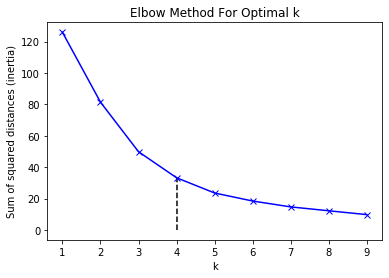

In [22]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances (inertia)')
plt.title('Elbow Method For Optimal k')
plt.vlines(x=4, ymin=0, ymax=inertias[3], color='k',linestyle='dashed')

plt.show()

In the plot above the elbow is at **k = 4** indicating the optimal k.

Now using this kvalue, determine the label for each postcode

In [23]:
kclusters = 4

km = KMeans(init="k-means++", n_clusters=kclusters, n_init=12, random_state=1234)
km.fit(cluster_dataset)
labels = km.labels_

dfpopfit["Labels"] = labels
dfpopfit.head(5)

,Postcode,Suburbs,long,lat,Population,Venue,fitPopulRatio,Labels
0,2000,"Dawes Point, Haymarket, Millers Point, Sydney,...",151.256649,-33.859953,5477,0.0,0.000000,0
1,2007,Ultimo,151.196650,-33.883189,1542,8.0,0.005188,2
2,2008,"Chippendale, Darlington",151.193858,-33.891146,2727,0.0,0.000000,0
3,2009,Pyrmont,151.193055,-33.871222,2913,3.0,0.001030,1
4,2010,"Surry Hills, Darlinghurst",151.212262,-33.884119,6774,7.0,0.001033,3


The centroid value for each cluster is determined by averaging the features in each cluster.

In [24]:
dfpopfit.groupby('Labels').mean()

,Postcode,long,lat,Population,Venue,fitPopulRatio
Labels,,,,,,
0,2029.526316,151.203350,-33.902722,2909.052632,0.684211,0.000206
1,2031.866667,151.207710,-33.885258,1744.133333,2.400000,0.001476
2,2019.000000,151.196730,-33.874658,2516.333333,7.666667,0.003768
3,2023.800000,151.233601,-33.907904,6343.600000,4.200000,0.000657


Count of postcodes in each cluster.

In [25]:
dfpopfit.groupby('Labels').count()

,Postcode,Suburbs,long,lat,Population,Venue,fitPopulRatio
Labels,,,,,,,
0,19,19,19,19,19,19,19
1,15,15,15,15,15,15,15
2,3,3,3,3,3,3,3
3,5,5,5,5,5,5,5


Finally, let's visualize the resulting clusters

In [26]:
# create map of Sydney using latitude and longitude values
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, pc, subs, ratio, cluster in zip(dfpopfit['lat'], dfpopfit['long'], dfpopfit['Postcode'], dfpopfit['Suburbs'], dfpopfit['fitPopulRatio'], dfpopfit['Labels']):
    label = folium.Popup(str(pc)+', '+subs+', '+str(ratio)+' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

map_clusters.save('map_clusters.html')

IPython.display.IFrame(src='./map_clusters.html', width=900, height=600)


### Cluster 1

In [27]:
bestpostcodes = dfpopfit.loc[dfpopfit['Labels'] == 0].sort_values(['fitPopulRatio', 'Population'], axis=0, ascending=[True,False]).head(10).reset_index(drop=True)

dfpopfit.loc[dfpopfit['Labels'] == 0].sort_values(['fitPopulRatio', 'Population'], axis=0, ascending=[True,False])


,Postcode,Suburbs,long,lat,Population,Venue,fitPopulRatio,Labels
0,2000,"Dawes Point, Haymarket, Millers Point, Sydney,...",151.256649,-33.859953,5477,0.0,0.000000,0
11,2020,Mascot,151.176775,-33.936179,3503,0.0,0.000000,0
2,2008,"Chippendale, Darlington",151.193858,-33.891146,2727,0.0,0.000000,0
10,2019,"Banksmeadow, Botany",151.207285,-33.946923,1782,0.0,0.000000,0
38,2047,Drummoyne,151.165735,-33.853924,1776,0.0,0.000000,0
39,2048,Stanmore,151.165640,-33.894180,1755,0.0,0.000000,0
35,2044,"St Peters, Sydenham, Tempe",151.170740,-33.920698,1644,0.0,0.000000,0
15,2024,"Bronte, Waverley",151.259392,-33.904414,1537,0.0,0.000000,0
20,2029,Rose Bay,151.266989,-33.875709,1361,0.0,0.000000,0
25,2034,"Coogee, South Coogee",151.252171,-33.929096,3980,1.0,0.000251,0


### Cluster 2

In [28]:
dfpopfit.loc[dfpopfit['Labels'] == 1].sort_values(['fitPopulRatio', 'Population'], axis=0, ascending=[True,False])

,Postcode,Suburbs,long,lat,Population,Venue,fitPopulRatio,Labels
21,2030,"Vaucluse, Watsons Bay, Dover Heights",151.275977,-33.858378,1233,1.0,0.000811,1
40,2049,"Lewisham, Petersham",151.150850,-33.897219,2271,2.0,0.000881,1
24,2033,Kensington,151.218435,-33.911390,2177,2.0,0.000919,1
18,2027,"Darling Point, Edgecliff, Point Piper",151.250494,-33.868972,1063,1.0,0.000941,1
3,2009,Pyrmont,151.193055,-33.871222,2913,3.0,0.001030,1
6,2015,"Alexandria, Beaconsfield, Eveleigh",151.194825,-33.910105,2883,3.0,0.001041,1
32,2041,"Balmain, Balmain East",151.180095,-33.858556,1726,2.0,0.001159,1
14,2023,Bellevue Hill,151.255910,-33.884685,1440,2.0,0.001389,1
34,2043,Erskineville,151.184665,-33.903521,2255,4.0,0.001774,1
41,2050,Camperdown,151.175980,-33.890370,2242,4.0,0.001784,1


### Cluster 3

In [29]:
dfpopfit.loc[dfpopfit['Labels'] == 2].sort_values(['fitPopulRatio', 'Population'], axis=0, ascending=[True,False])

,Postcode,Suburbs,long,lat,Population,Venue,fitPopulRatio,Labels
5,2011,"Woolloomooloo, Elizabeth Bay, Potts Point, Rus...",151.221626,-33.873599,4762,10.0,0.002100,2
30,2039,Rozelle,151.171915,-33.867187,1245,5.0,0.004016,2
1,2007,Ultimo,151.196650,-33.883189,1542,8.0,0.005188,2


### Cluster 4

In [30]:
dfpopfit.loc[dfpopfit['Labels'] == 3].sort_values(['fitPopulRatio', 'Population'], axis=0, ascending=[True,False])

,Postcode,Suburbs,long,lat,Population,Venue,fitPopulRatio,Labels
8,2017,"Waterloo, Zetland",151.206316,-33.903892,6358,3.0,0.000472,3
17,2026,Bondi,151.268968,-33.891041,6979,4.0,0.000573,3
26,2035,"Maroubra, Pagewood",151.241292,-33.945635,4996,3.0,0.000600,3
22,2031,"Clovelly, Randwick",151.239167,-33.914832,6611,4.0,0.000605,3
4,2010,"Surry Hills, Darlinghurst",151.212262,-33.884119,6774,7.0,0.001033,3


[TOP](#TOC)

# Results<a name="results"></a>

From the above clustering excercise, it is clear postcodes in **Cluster 1** has the lowest density of Fitness centres and **Cluster 3** has the highest density of Fitness centres 

In [31]:
bestpostcodes

,Postcode,Suburbs,long,lat,Population,Venue,fitPopulRatio,Labels
0,2000,"Dawes Point, Haymarket, Millers Point, Sydney,...",151.256649,-33.859953,5477,0.0,0.000000,0
1,2020,Mascot,151.176775,-33.936179,3503,0.0,0.000000,0
2,2008,"Chippendale, Darlington",151.193858,-33.891146,2727,0.0,0.000000,0
3,2019,"Banksmeadow, Botany",151.207285,-33.946923,1782,0.0,0.000000,0
4,2047,Drummoyne,151.165735,-33.853924,1776,0.0,0.000000,0
5,2048,Stanmore,151.165640,-33.894180,1755,0.0,0.000000,0
6,2044,"St Peters, Sydenham, Tempe",151.170740,-33.920698,1644,0.0,0.000000,0
7,2024,"Bronte, Waverley",151.259392,-33.904414,1537,0.0,0.000000,0
8,2029,Rose Bay,151.266989,-33.875709,1361,0.0,0.000000,0
9,2034,"Coogee, South Coogee",151.252171,-33.929096,3980,1.0,0.000251,0


[TOP](#TOC)

# Discussion<a name="discussion"></a>

As shown in the "Results" section, there are **ten (10)** narrowed down list of postcodes.   

The major observation is 9 out of 10 postcodes have no fitness centres but with high target demographic. Next step would be to use these postcodes and consider other features, such as land area of the postcode and rental price of commercial properties. This would allow to establish financial viability and geographical suitability for a fitness centre   

[TOP](#TOC)

# Conclusion<a name="conclusion"></a>

The objective was to identify 10 best postcodes within inner Sydney to establish a fitness centre. Features considered were demographic, 20-39 year olds whose weekly income between AUD 1000 - 1999. Other feature was count of fitness centres already in each postcode.  

Using Fitness centre data from Fourquare and postcode data scrapped from various websites, density in each postcode was established and segmented into 4 clusters. Giving one cluster with lowest density. From this cluster 10 best postcodes were selected with lower fitness centre density and higher demographic.

The findings in this report can be used by the stakeholders to start scouting for locations within the best postcodes. Furhter considerations would be to look at features such as land area and rental price of commercial properties.

[TOP](#TOC)